Este archivo es para implementar algunos algoritmos de aprendizaje por refuerzo y aplicarlos utilizando Open AI gym.

Se van a probar los siguientes 2 entornos (environments), de acuerdo con los resultados presentados en el articulo de Diego:

Pendulum-v0 y Hopper-v2

Tareas (Puede cambiar):
1. Terminar el curso de David Silver. (Completo: 100%)
2. Implementar con table lookup. (Completo: 100%)
3. Implementar con DQN. (Completo: 100%)
4. Implementar con Simglucose (Sin comenzar)
5. Implementar con el trabajo de Diego. (Sin comenzar)

6. Adicional: Optimizar el codigo. 

# Instalación

In [1]:
#Correr esta celda si se utiliza Google Colab con un ambiente remoto.
!pip install progressbar2
!pip install gym

# Librerías

In [1]:
import time, copy, random
import numpy as np
import pandas as pd

import progressbar
import gym

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.initializers import RandomNormal

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Clases

In [2]:
class ExperienceReplay():
    def __init__(self, tamano_minimo = 1000, tamano_maximo = 10**5, tamano_batch = 32, column_names = ['St', 'At', 'St+1', 'Rt+1', 'done']):
        self.tamano_buffer = 0
        self.indice = 0
        self.tamano_batch = tamano_batch
        self.tamano_minimo = tamano_minimo
        self.tamano_maximo = tamano_maximo
        self.columnas = column_names
        
        self.buffer = self.inicializarBuffer()
        self.buffer.columns = column_names
        #self.indices = range(self.tamano_maximo)
    
    def inicializarBuffer(self):
        aux = pd.DataFrame(np.zeros((10**4,5)), dtype = 'object')
        #aux = pd.DataFrame({'St': None, 'At': [np.array([0,0])],
        #                   'Rt+1': [np.array([0,0])], 'St+1': [np.array([0,0])],
        #                   'done': [np.array([0,0])]})
        
        buffer = []
        
        for i in range(int(self.tamano_maximo/10**4)):
            buffer.append(aux)
        
        return pd.concat(buffer)
    
    def agregarDato(self, x, a, r, xp, d):
        
        if(self.indice == self.tamano_maximo):
            self.indice = 0
            
        self.buffer.iloc[self.indice]['St'] = x
        self.buffer.iloc[self.indice]['At'] = a
        self.buffer.iloc[self.indice]['Rt+1'] = r
        self.buffer.iloc[self.indice]['St+1'] = xp
        self.buffer.iloc[self.indice]['done'] = d

        self.indice +=1
        
        if self.tamano_buffer < self.tamano_maximo:
            self.tamano_buffer += 1
    
    def darMuestras(self):
        #indices = random.sample(self.indices[0:self.tamano_buffer], self.tamano_batch)
        indices = random.sample(range(self.tamano_buffer), self.tamano_batch)
        return self.buffer.iloc[indices]


# Table Lookup

Pendulum-v0<br /> 
Utilizando el algoritmo de Sarsa.<br />
Está como chambón pero funciona.

In [ ]:
def darIndice(pS):
    return int(round(pS, 1)*10+10)

def escogerAccion(pS1, pS2, pS3):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0,41)
        return ind
    else:
        ind = np.where(tablaQ[pS1, pS2, pS3, :] == np.amax(tablaQ[pS1, pS2, pS3, :]))
        ind = ind[0]
        
        if(len(ind) > 1):
            return np.random.choice(ind)
        else:
            return ind
    
    return accion

In [ ]:
envName = 'Pendulum-v0'

g = 0.9
alpha = 0.5
epsilon = 0.1 #Entre 0 y 1
maxIter = 1500000
ventana = 100
epsilonIterLimit = maxIter*0.9

tablaQ = np.ones((21,21,17,41))*-16
rewards = np.zeros(int(maxIter/10))

env = gym.make(envName)
observation = env.reset()

s1 = darIndice(observation[0])
s2 = darIndice(observation[1])
s3 = int(round(observation[2], 0) + 8)
a = escogerAccion(s1, s2, s3)

suma = 0

for i in progressbar.progressbar(range(maxIter)):
    
    if(i > maxIter-2000):
        env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(r + g*tablaQ[s1p, s2p, s3p, ap] - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
    if(i > epsilonIterLimit):
        epsilon = 0
    
env.close()

In [ ]:
for i in progressbar.progressbar(range(2000)):
    env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(r + g*tablaQ[s1p, s2p, s3p, ap] - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
env.close()

# DQN

In [3]:
envName = 'Pendulum-v0'
env = gym.make(envName) 

num_acciones = 41
dim_state = 3

#Creando redes neuronales
def crearRedes(n1 = 20, n2 = num_acciones, learning_rate = 0.01):
    init = RandomNormal(seed = 0)
    
    modelo = Sequential()
    
    modelo.add(Dense(n1, activation = 'relu', kernel_initializer = init, bias_initializer = init, input_dim = dim_state))
    modelo.add(Dense(n1, activation = 'relu', kernel_initializer = init, bias_initializer = init))
    modelo.add(Dense(n2, activation = 'linear', kernel_initializer = init, bias_initializer = init))
    
    sgd = optimizers.sgd(lr = learning_rate)
    
    modelo.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])
    
    return modelo, copy.deepcopy(modelo)

def actualizarRedTarget(pRedPrincipal, pRedTarget):
    
    for i in range(len(pRedPrincipal.layers)):
        pesosPrincipal = pRedPrincipal.layers[i].get_weights()
        pesosTarget = pRedTarget.layers[i].get_weights()
        
        pesos = [tao*l1 + (1-tao)*l2 for l1, l2 in zip(pesosPrincipal, pesosTarget)]
        
        pRedTarget.layers[i].set_weights(pesos)

def escogerAccion(pModelo, pX):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0, num_acciones)
        return ind
    else:
        ind = np.argmax(pModelo.predict(pX))
        return ind

/home/hero/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Entrenando el Agente

100% (2000 of 2000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:09:44 Time:  0:09:44


Total training time:  585.86 seconds


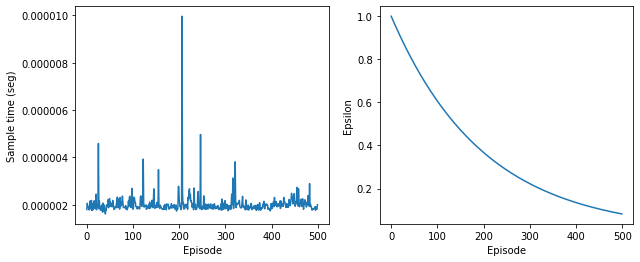

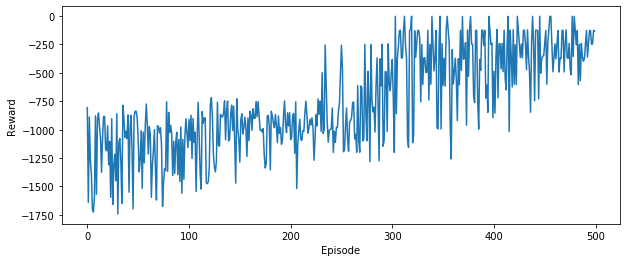

In [17]:
np.random.seed(123)

buffer = ExperienceReplay(tamano_minimo = 2000)

red, red_target = crearRedes(learning_rate = 0.05)

num_episodes = 500
num_steps = 500
epsilon = 1.0
epsilon_decay = 0.995
tao = 0.001
gamma = 0.99
batch_size = 32

total_steps_log = []
epsilon_log = []
muestras_log = []
rewards_acumulados = []

state = env.reset()

state[2] *= 1/8.0
state = np.reshape(state, (1,-1))

initial_time = time.time()

for s in progressbar.progressbar(range(buffer.tamano_minimo)):
    action = np.random.randint(num_acciones)
    
    next_state, reward, done, info = env.step([(action-20.0)/10.0])
    next_state[2] *= 1/8.0
    next_state = np.reshape(next_state, (1, -1))
    
    buffer.agregarDato(state, action, reward, next_state, done)
    
    state = next_state

for e in progressbar.progressbar(range(num_episodes)):
    state = env.reset()
    state[2] *= 1/8.0
    state = np.reshape(state, (1, -1))
    
    rewardAcumulado = 0
    
    for s in range(num_steps):
        if(np.random.random() <= epsilon):
            action = np.random.randint(num_acciones)
        else:
            action = np.argmax(red.predict(state))
            
        next_state, reward, done, info = env.step([(action-20.0)/10.0])
        next_state[2] *= 1/8.0
        next_state = np.reshape(next_state, (1, -1))
        
        buffer.agregarDato(state, action, reward, next_state, done)
       
        state = next_state
        
        sumaMuestras = 0
        
        tm = time.time()
        muestras = buffer.darMuestras()
        sumaMuestras += time.time()-tm

        states = np.concatenate(muestras['St'].values)
        actions = muestras['At'].values
        rewards = muestras['Rt+1'].values
        next_states = np.concatenate(muestras['St+1'].values)
        dones = muestras['done'].values

        Q_values = red.predict(states)

        next_Q_values = red_target.predict(next_states)
        targets = Q_values.copy()   # Set initial target values

        targets[np.arange(buffer.tamano_batch), list(actions)] = rewards + gamma* np.max(next_Q_values, axis = 1) * (1 - dones)

        red.train_on_batch(states, targets)

        actualizarRedTarget(red, red_target)

        rewardAcumulado += reward
        
        if(done):
            break    
    
    sumaMuestras *= 1/float(s)
    muestras_log.append(sumaMuestras)
    rewards_acumulados.append(rewardAcumulado)
    
    total_steps_log.append(s)
    epsilon_log.append(epsilon)
    epsilon = epsilon_decay * epsilon

total_training_time = time.time() - initial_time

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(muestras_log)
plt.xlabel('Episode')
plt.ylabel('Sample time (seg)')

plt.subplot(122)
plt.plot(epsilon_log)
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.figure(figsize=(10,4))
plt.plot(rewards_acumulados)
plt.xlabel('Episode')
plt.ylabel('Reward')

print('Total training time: ', np.round(total_training_time, 2), 'seconds')

# Probando el Agente

In [20]:
steps_prueba = 250

state = env.reset()
state[2] *= 1/8.0
state = np.reshape(state, (1, -1))

for s in range(steps_prueba):
    
    action = np.argmax(red.predict(state))
    state, reward, done, info = env.step([(action-20.0)/10.0])
    
    state[2] *= 1/8.0
    state = np.reshape(state, (1, -1))

    env.render()
    
env.close()